# Hybrid Classic-Quantum Systems - Third Assignment #

You should fill in this Jupyter notebook in order to complete the assignment. Here a small recap of the rules:

* You should **NOT** modify the functions that are already provided in the notebook, unless it is strictly necessary;
* If you want to modify the given functions, please, provide an explanation of why you had to;
* You can define new functions, as soon as they are well commented;
* You can import all libraries you want, as soon as you justify their utilization;
* You can add new cells, as soon as you do not remove the cells where you are supposed to comment your solution;
* This is a group assignment. The maximum number of people is 3;
* Your solution should be commented and accompanied by a small description - you can add additional cells if needed;
* For any issue and doubt, please do not hesitate to use the forum or to write me an email.

# Preliminaries #

## Bin Packing Problem (BPP) ##
The bin packing problem (BPP) is an optimization problem. The final goal is to fit items of different sizes into a finite number of bins, each of a fixed given capacity, minimizing the number of bins used. The problem has many applications, ranging from logistics, multi-processor scheduling.

Computationally, the problem is NP-hard, and the corresponding decision problem, deciding if items can fit into a specified number of bins, is NP-complete.
![np-complete](https://imgs.xkcd.com/comics/np_complete.png)

## Mathematical formulation ##
The objective function of BPP is to minimize the number of bins used, more formally,
\begin{align} \label{eqn:bpp}
    & {\min}
    & &  \sum_{j=1}^{K} B_j \\
    & {\text{subject to}}
    & & g(x_{ij}) = \sum_{j=1}^{K} x_{ij} = 1 \qquad \forall i \\
    & & & h(x_{ij}) = \sum_{i=1}^N w_{i}x_{ij} \le C*B_j \qquad \forall j
\end{align}

The constraint $g(x)$ implies that each task can be packed into at most one CPU, and constraint $h(x_{ij})$ says that the requirements of each task can not exceed the given $C$ capacity. In this paper, BPP can be considered as a mixture of inequality and equality-constrained optimization problems.

# Loading BPP instances #
First of all, we focus on generating instances of BPP to be used for the evaluation. Each instance is structured in the following way:

$[[w_0, w_1, ..., w_n], C, B, items]$, such that:
* $w_i$ is the weight of item $i$;
* $C$ is the capacity of each bin;
* $B$ is the number of bins;
* $items$ is the number of items

We pre-generated the instances for you and saved them in an attached binary file. You can read them in your code by using the following code:

In [1]:
import pickle

def read_list(filename):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

# Transforming BPP into a QUBO #
QUBO is a mathematical model that is used to represent combinatorial optimization problems in which the variables are binary $\{0,1\}$ and the objective function with constraints is quadratic. We employ QUBO for BPP because it provides a framework for representing combinatorial optimization problems in a form that can be efficiently solved using quantum computing algorithms designed for QUBO problems, such as VQE or QAOA.

## Slack Variables + Quadratic Penalty Encoding ##
Qiskit Optimization provides with QuadraticProgram a very generic and powerful representation for optimization problems. However, usually, optimization algorithms cannot handle all possible types of problems that can be modelled, but only a sub-class. Many available quantum optimization algorithms can handle Quadratic Unconstrained Binary Optimization (QUBO) problems. To do so, first, it is necessary to convert a given optimization problem into a QUBO.

Qiskit Optimization provides converters to achieve this conversion whenever possible. More precisely, Qiskit Optimization provides the following converters: 
* *InequalityToEquality*: converts inequality constraints into equality constraints with additional slack variables.
* *IntegerToBinary* : converts integer variables into binary variables and corresponding coefficients. 
* *LinearEqualityToPenalty* : convert equality constraints into additional terms of the object function. 
* *QuadraticProgramToQubo* : a wrapper for IntegerToBinary and LinearEqualityToPenalty for convenience.
More information available at: https://qiskit.org/documentation/stable/0.19/tutorials/optimization/2_converters_for_quadratic_programs.html

## Penalty-Based Encoding ##

### Define penalties ###
To enforce the constraints, we introduce penalty terms to the objective function. These terms penalize solutions that violate the constraints. Firsts, we rewrite constraints $g(x_{ij})$ and $h(x_{ij})$ as follows,
     \begin{align*}
        g(x_{ij}) = \sum_{j=1}^{K} x_{ij} - 1 = 0 \qquad \forall i \\
        h(x_{ij}) = \sum_{i=1}^N w_{i}x_{ij} - C \cdot B_j \le 0 \qquad \forall j \\
    \end{align*}
    Second, introduce penalty functions $p_1(\lambda, g(x))$ and $p_2(\beta, h(x))$ with coefficients $\{\lambda, \beta\} \geq 0 $
    \begin{equation}\label{penalty1}
        p_1(\lambda, g(x_{ij})) =
        \begin{cases}
            0 & \text{if $g(x_{ij}) \leq 0$} \\
            \lambda g(x_{ij}) & \text{if $g(x_{ij}) > 0$} 
        \end{cases}
    \end{equation}
    \begin{equation}\label{penalty2}
        p_2(\beta, h(x_{ij})) =
        \begin{cases}
            0 & \text{if $h(x_{ij}) \leq 0$} \\
            \beta h(x_{ij}) & \text{if $h(x_{ij}) > 0$} 
        \end{cases} 
    \end{equation}
    
In literature, there are multiple methods for penalization such as the exterior penalty function and interior penalty function.

### Injecting Penalties in the Model ###
To get the final QUBO form we combine penalties with objective function and get

\begin{equation}
    \mathcal{F} = \sum_{j=1}^{K} B_j + \sum_{j=1}^{K}p_1(\lambda, g_j) + \sum_{i=1}^{N}p_2(\beta,h_i)
\end{equation}

### Examples of penalty functions ###
* https://www.stat.cmu.edu/~ryantibs/convexopt-F13/scribes/lec16.pdf
* https://www.rose-hulman.edu/~bryan/lottamath/penalty.pdf

## YOUR TASK ##
* Apply slack + quadratic penalty
* Apply penalty-based encoding using three functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

from qiskit import BasicAer
import qiskit_algorithms
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization import QuadraticProgram

from qiskit_optimization.converters import InequalityToEquality, IntegerToBinary, LinearEqualityToPenalty

from qiskit_optimization.translators import from_docplex_mp

def data_bins(results, wj, n, m, l=0, simplify=False):
    """save the results on a dictionary with the three items, bins, items, and index.
    results (cplex.solve): results of the optimization
    wj: (array (1,m): weights of the items
    n: (int) number of items
    m: (int) number of bins
    """
    if simplify:
        bins = np.ones((m,))
        if m-l > 0: 
            bins[m-l-1:m] = results[:m-l]
        items = np.zeros((m,n))
        items[:,1:] = results[m-l:(m-1)*n+m-l].reshape(m,n-1)
        items[0,0] = 1
        items = items.reshape(m,n) * wj
        return {"bins":bins, "items":items,"index":np.arange(m)}
    else:        
        return {"bins":results[:m], "items":results[m:m+m*n].reshape(m,n) * wj, "index":np.arange(m)}

def plot_bins(results, wj, n, m, l=0,simplify=False):
    """plot in a bar diagram the results of an optimization bin packing problem"""
    res = data_bins(results.x, wj, n, m, l, simplify)
    plt.figure()
    ind = res["index"]
    plt.bar(ind, res["items"][:,0], label=f"item {0}")
    suma = bottom=res["items"][:,0]
    for j in range(1,n):
        plt.bar(ind, res["items"][:,j], bottom=suma, label=f"item {j}")
        suma += res["items"][:,j]
    plt.hlines(Q,0-0.5,m-0.5,linestyle="--", color="r",label="Max W")
    plt.xticks(ind)
    plt.xlabel("Bin")
    plt.ylabel("Weight")
    plt.legend()

## BIN PACKING SIMPLIFY

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: x2 + 2
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: 9 _e0,1 + 23 _e0,2 <= 24
 cons1,1: 9 _e1,1 + 23 _e1,2 <= 40
 cons1,2: - 40 x2 + 9 _e2,1 + 23 _e2,2 <= 0

Bounds
 0 <= x2 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1

Binaries
 x2 _e0,1 _e0,2 _e1,1 _e1,2 _e2,1 _e2,2
End

fval=2.0, x2=0.0, e0,1=0.0, e0,2=0.0, e1,1=1.0, e1,2=1.0, e2,1=0.0, e2,2=0.0, status=SUCCESS


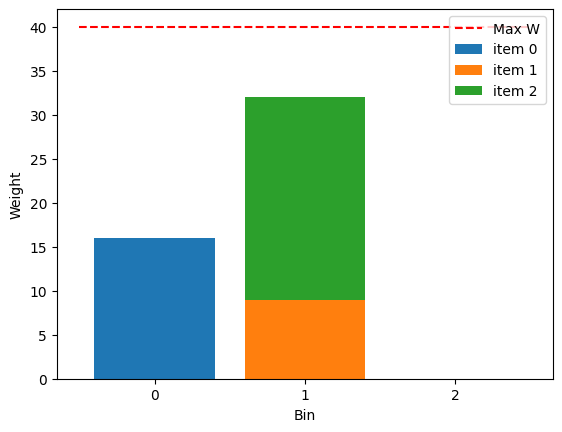

In [3]:
np.random.seed(2)
n = 3 # number of bins
m = n # number of items
Q = 40 # max weight of a bin

wj = np.random.randint(1,Q,n) # Randomly picking the item weight

mdl = Model("BinPacking_simplify")

l = int(np.ceil(np.sum(wj)/Q))
x = mdl.binary_var_list([f"x{i}" for i in range(m)]) # list of variables that represent the bins
e =  mdl.binary_var_list([f"e{i//m},{i%m}" for i in range(n*m)]) # variables that represent the items on the specific bin

objective = mdl.sum([x[i] for i in range(n)])

mdl.minimize(objective)

for j in range(m):
    # First set of constraints: the items must be in any bin
    constraint0 = mdl.sum([e[i*m+j] for i in range(n)])
    mdl.add_constraint(constraint0 == 1, f"cons0,{j}")
    
for i in range(n):
    # Second set of constraints: weight constraints
    constraint1 = mdl.sum([wj[j] * e[i*m+j] for j in range(m)])
    mdl.add_constraint(constraint1 <= Q * x[i], f"cons1,{i}")


# Load quadratic program from docplex model
#qp = QuadraticProgram()
qp = from_docplex_mp(mdl)
# Simplifying the problem
for i in range(l):
    qp = qp.substitute_variables({f"x{i}":1}) 
qp = qp.substitute_variables({"e0,0":1}) 
for i in range(1,m):
    qp = qp.substitute_variables({f"e{i},0":0})
print(qp.export_as_lp_string())

cplex = CplexOptimizer()
simplify_result = cplex.solve(qp)
print(simplify_result)
plot_bins(simplify_result, wj, n, m, l, simplify=True)

## QUBO Representation

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: x2 + 2
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: 9 _e0,1 + 23 _e0,2 + cons1,0@int_slack = 24
 cons1,1: 9 _e1,1 + 23 _e1,2 + cons1,1@int_slack = 40
 cons1,2: - 40 x2 + 9 _e2,1 + 23 _e2,2 + cons1,2@int_slack = 0

Bounds
 0 <= x2 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1
       cons1,0@int_slack <= 24
       cons1,1@int_slack <= 40
       cons1,2@int_slack <= 40

Binaries
 x2 _e0,1 _e0,2 _e1,1 _e1,2 _e2,1 _e2,2

Generals
 cons1,0@int_slack cons1,1@int_slack cons1,2@int_slack
End

The number of variables is 10
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: x2 + 2
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: 9 _e0,1 + 23 _e0,2 + cons1,0@int_slack@0 +

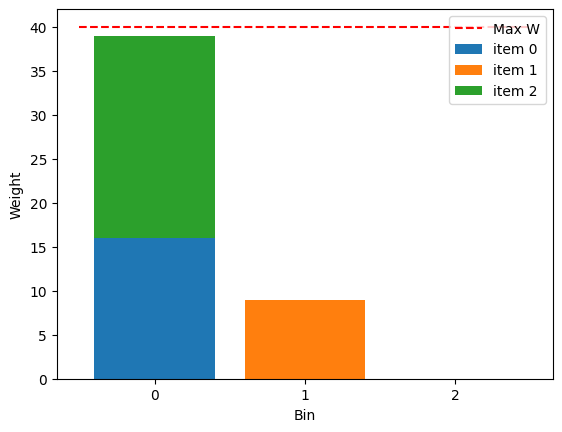

In [4]:
ineq2eq = InequalityToEquality()
qp_eq = ineq2eq.convert(qp)
print(qp_eq.export_as_lp_string())
print(f"The number of variables is {qp_eq.get_num_vars()}")

int2bin = IntegerToBinary()
qp_eq_bin = int2bin.convert(qp_eq)
print(qp_eq_bin.export_as_lp_string())
print(f"The number of variables is {qp_eq_bin.get_num_vars()}")

lineq2penalty = LinearEqualityToPenalty()
qubo = lineq2penalty.convert(qp_eq_bin)
print(f"The number of variables is {qp_eq_bin.get_num_vars()}")
print(qubo.export_as_lp_string())

result = cplex.solve(qubo)
print(result)

data_bins(result.x, wj, n, m, l, simplify=True)
plot_bins(result, wj, n, m, l, simplify=True)

# Encoding QUBO into ISING Hamiltonian #
The next step is to encode the classical QUBO formulation into a quantum state. There exist techniques to encode classical data into quantum such as basis encoding, amplitude encoding, and angle encoding. In this paper, we apply basis encoding, for which any quantum basis can be chosen, but the common way for doing so is to choose basis $\{-1,1\}$ as follows:
\begin{align}
\label{eqn:to_ising}
    \begin{split}
    x_i = \frac{1-z_i}{2}\\
    z_i*z_j = \sigma_Z^i \otimes \sigma_Z^j \\
    z_i = \sigma_Z^i
    \end{split}
\end{align}
where $\sigma_Z^i$ denotes the Pauli-Z matrix 
$\begin{pmatrix}
  1 & 0\\ 
  0 & -1
\end{pmatrix}$ on the $i$-th qubit.
The eigenvalues of $\text{I} - \frac{Z}{2}$ are $\{-1,1\}$ with corresponding eigenstates $|0\rangle$ and $|1\rangle$. Thus, we switch from Z to $\text{I} - \frac{Z}{2}$, and rewrite the problem as BPP Ising hamiltonian,
\begin{equation} \label{eqn:final_hamiltonian}
    H_{bpp}= \sum_{j=1}^{K} \sigma_j + \sum_{j=1}^{K}p_1(\lambda, g_j) + \sum_{i=1}^{N}p_2(\beta,h_i)
\end{equation}
where $g_j$ and $h_i$ are now functions of $\sigma$.

## YOUR TASK: Encoding the QUBO as an Ising Hamiltonian ##

In [5]:
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA

sampler = Sampler()
optimizer = COBYLA()

qaoa = QAOA(reps=1, sampler=sampler, optimizer=optimizer)

# QUBO as an Ising Hamiltonian
operator, offset = qubo.to_ising()

result_qaoa = qaoa.compute_minimum_eigenvalue(operator=operator)

print(result_qaoa)

plot_bins(result, wj, n, m, l, simplify=True)
plt.title("QAOA solution", fontsize=18)

MemoryError: Unable to allocate 31.5 GiB for an array with shape (24, 16777216) and data type <U21

# Solving BPP instances #
Solve each problem instances using different methods:
## CPLEX optimizer ##
Classic optimizer, to be used as baseline with all the others.

In [ ]:
from docplex.mp.model import Model
from qiskit_optimization.algorithms import CplexOptimizer

## QAOA solution ##


In [ ]:
from qiskit.algorithms.minimum_eigensolvers import QAOA

## Warm start QAOA ##

In [ ]:
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer

# Evaluation #

Evaluate quantum solutions in comparison with classic solution using the following metrics:
* Running time;
* Mean square error between quantum optimum and classic optimum;
* Number of times each algorithm reaches the optimum;

Evaluation should be performed on the following backends:
* Noiseless simulator (Aer)
* Noisy simulator (choose a noise model)
* BONUS: test on AQT simulator (check https://github.com/qiskit-community/qiskit-aqt-provider)

QAOA should be evaluated using different configurations:
* QAOAAnsatz with $p=[1,5]$ 
* Optimizers: COBYLA, NelderMead, SLSQP
* Shots: {200, 400, 600, 800, 1000} (Please note that AQT backend is limited to 200 shots)
* Optimizers' iteration: {250, 500, 750, 1000}